In [1]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt

In [12]:
def extract_hyperparameters(config_path):
    with open(config_path, 'r') as f:
        content = f.read()

    pattern = r"Recompensas ai_rl_1:\s*([-+]?\d*\.?\d+),\s*([-+]?\d*\.?\d+)\s*Recompensas ai_rl_2:\s*([-+]?\d*\.?\d+),\s*([-+]?\d*\.?\d+)"
    match = re.search(pattern, content)
    
    if not match:
        raise ValueError(f"Parameters were not found: {config_path}")

    alpha_1, beta_1, alpha_2, beta_2 = map(float, match.groups())
    return alpha_1, beta_1, alpha_2, beta_2

In [13]:
def process_files(base_dir="/data/samuel_lozano"):
    all_data = []

    for subfolder in os.listdir(base_dir):
        subfolder_path = os.path.join(base_dir, subfolder)
        if os.path.isdir(subfolder_path):
            config_path = os.path.join(subfolder_path, 'config.txt')
            reward_path = os.path.join(subfolder_path, 'reward_data.csv')

            if not (os.path.exists(config_path) and os.path.exists(reward_path)):
                print(f"Skiping {subfolder_path}: files missing.")
                continue

            try:
                alpha_1, beta_1, alpha_2, beta_2 = extract_hyperparameters(config_path)
                df = pd.read_csv(reward_path)
                df['alpha_1'] = alpha_1
                df['beta_1'] = beta_1
                df['alpha_2'] = alpha_2
                df['beta_2'] = beta_2
                df['source_folder'] = subfolder  # opcional: para identificar la fuente
                all_data.append(df)
            except Exception as e:
                print(f"Error processing {subfolder_path}: {e}")

    if all_data:
        combined_df = pd.concat(all_data, ignore_index=True)
        output_path = os.path.join(base_dir, 'experiment_results.csv')
        combined_df.to_csv(output_path, index=False)
        print(f"Final file saved in: {output_path}")
    else:
        print("Data was not found.")

In [14]:
brigit = "/mnt/lustre/home/samuloza"
map_nr = 1
base_load_dir = f"{brigit}/data/samuel_lozano/cooked/saved_models/map_{map_nr}/"

process_files(base_dir=base_load_dir)

Final file saved in: /mnt/lustre/home/samuloza/data/samuel_lozano/cooked/saved_models/map_1/experiment_results.csv


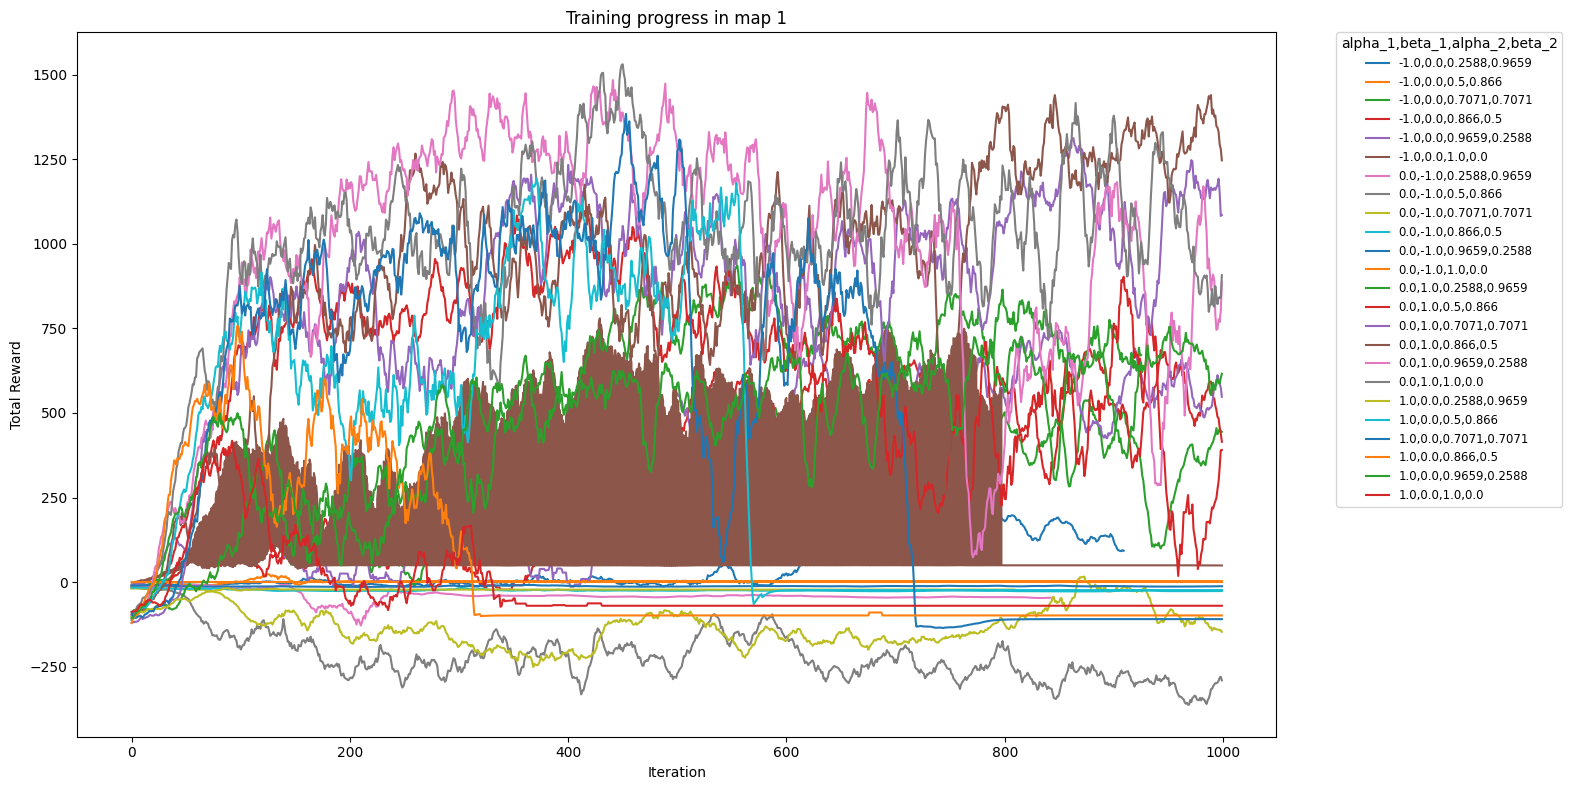

In [15]:
csv_path = os.path.join(base_load_dir, "experiment_results.csv")

if not os.path.exists(csv_path):
    raise FileNotFoundError(f"Not found {csv_path}")
df = pd.read_csv(csv_path)

required_columns = ['iteration', 'total_reward', 'alpha_1', 'beta_1', 'alpha_2', 'beta_2']
if not all(col in df.columns for col in required_columns):
    raise ValueError(f"Missing columns. Expected: {required_columns}")

grouped = df.groupby(['alpha_1', 'beta_1', 'alpha_2', 'beta_2'])

plt.figure(figsize=(20, 8))
for (a1, b1, a2, b2), group in grouped:
    group_sorted = group.sort_values(by="iteration")
    label = f"{a1},{b1},{a2},{b2}"
    plt.plot(group_sorted['iteration'], group_sorted['total_reward'], label=label)
plt.title(f"Training progress in map {map_nr}")
plt.xlabel("Iteration")
plt.ylabel("Total Reward")
plt.legend(title="alpha_1,beta_1,alpha_2,beta_2",
           bbox_to_anchor=(1.05, 1),
           loc='upper left',
           borderaxespad=0.,
           fontsize='small')
plt.tight_layout(rect=[0, 0, 0.8, 1]) 
plt.show()

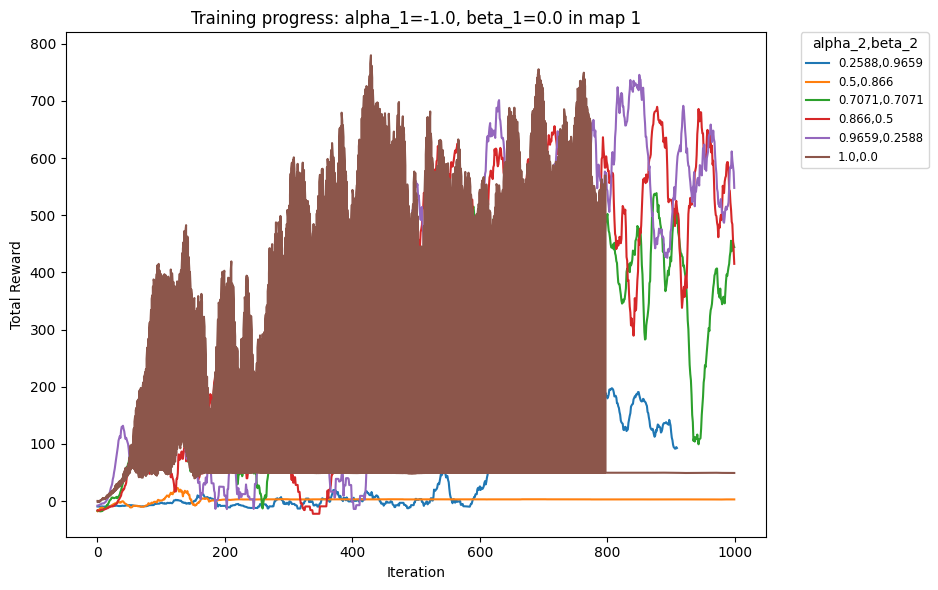

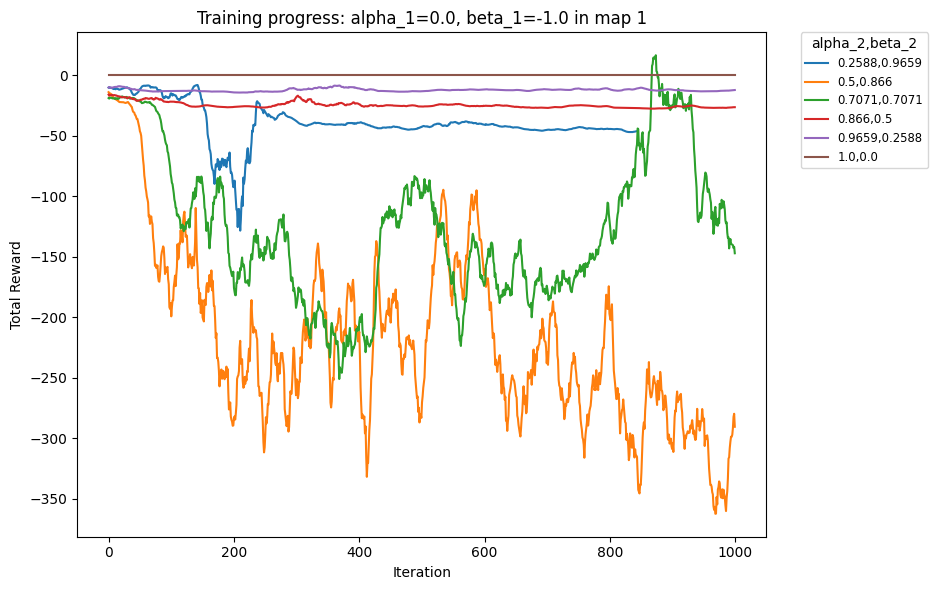

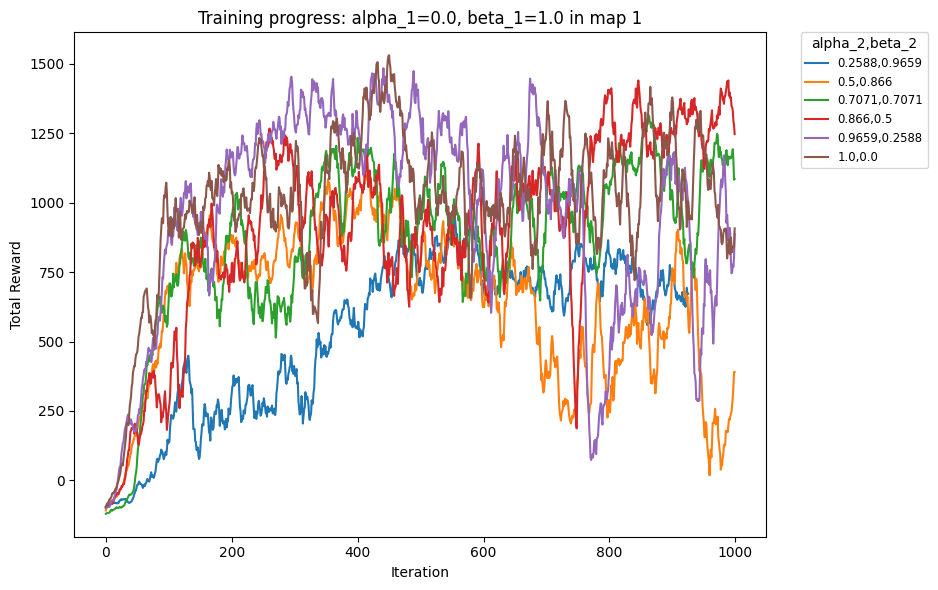

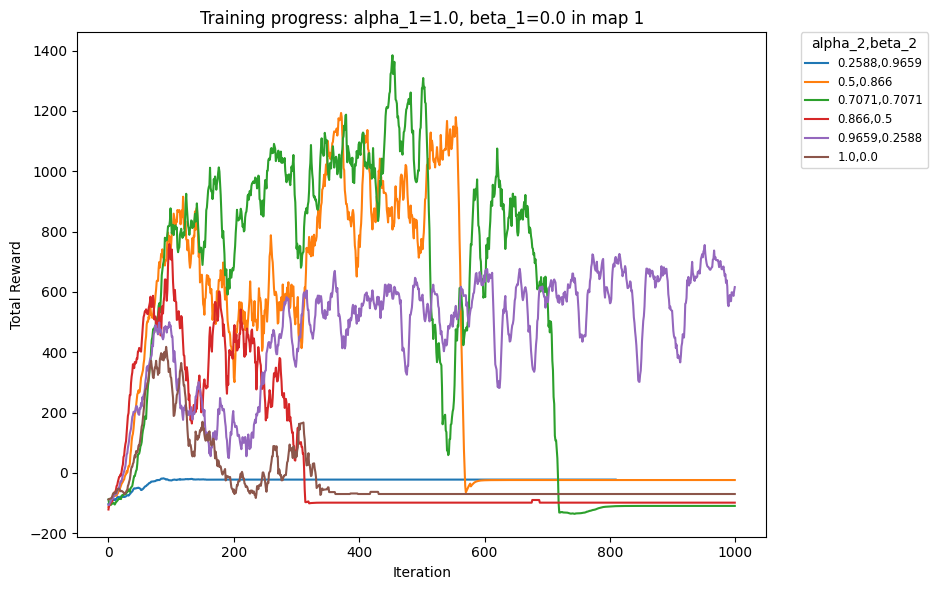

In [16]:
group_by_agent_1 = df.groupby(['alpha_1', 'beta_1'])

for (a1, b1), group_df in group_by_agent_1:
    plt.figure(figsize=(12, 6))
    title = f"alpha_1={a1}, beta_1={b1} in map {map_nr}"
    
    inner_groups = group_df.groupby(['alpha_2', 'beta_2'])
    for (a2, b2), subgroup in inner_groups:
        subgroup_sorted = subgroup.sort_values(by="iteration")
        label = f"{a2},{b2}"
        plt.plot(subgroup_sorted['iteration'], subgroup_sorted['total_reward'], label=label)
    plt.title(f"Training progress: {title}")
    plt.xlabel("Iteration")
    plt.ylabel("Total Reward")

    plt.legend(title="alpha_2,beta_2",
               bbox_to_anchor=(1.05, 1),
               loc='upper left',
               borderaxespad=0.,
               fontsize='small')
    plt.tight_layout(rect=[0, 0, 0.8, 1])
    plt.show()